In [ ]:
pip install mediapipe opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [ ]:
import cv2
import mediapipe as mp
import os
import json

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)

mp_drawing = mp.solutions.drawing_utils


In [ ]:
# Directories for forehand and backhand images
forehand_dir = "/Tennis/Forehand/"
backhand_dir = "/Tennis/Backhand/"

In [ ]:
output_directory = "/Tennis/"
output_file = "pose_data_with_labels.json"

In [ ]:
# Function to extract pose keypoints from images
def process_images(image_directory, label):
    pose_data = []

    for filename in os.listdir(image_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_directory, filename)

            # Read image with OpenCV
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # MediaPipe expects RGB images

            # Perform pose detection
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                # Extract keypoints
                keypoints = []
                for landmark in results.pose_landmarks.landmark:
                    keypoints.append([landmark.x, landmark.y, landmark.z])  # Normalize coordinates to [0, 1]

                # Add keypoints and label to the dataset
                pose_data.append({
                    "keypoints": keypoints,
                    "label": label
                })

    return pose_data

In [ ]:
# Process both forehand and backhand images
forehand_pose_data = process_images(forehand_dir, "forehand")
backhand_pose_data = process_images(backhand_dir, "backhand")


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [ ]:
# Combine data
all_pose_data = forehand_pose_data + backhand_pose_data

In [ ]:
# Check if the directory exists, if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the data with labels to a JSON file
with open(output_file, "w") as f:
    json.dump(all_pose_data, f)

print(f"Pose data with labels saved to {output_file}")

Pose data with labels saved to pose_data_with_labels.json


# **Training the model **

In [ ]:
import json
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
# Load the pose data with labels
with open("/Tennis/pose_data_with_labels.json", "r") as f:
    data = json.load(f)

# Prepare the data for training
X = []  # Feature data (pose keypoints)
y = []  # Labels (forehand or backhand)

for entry in data:
    keypoints = [coord for kp in entry["keypoints"] for coord in kp]  # Flatten keypoints to a 1D list
    X.append(keypoints)
    y.append(entry["label"])

X = np.array(X)
y = np.array(y)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train a Support Vector Machine (SVM) classifier
svm_clf = SVC(kernel="linear")
svm_clf.fit(X_train, y_train)

joblib.dump(svm_clf, "svm_model.pkl")


['svm_model.pkl']

In [ ]:
# Evaluate the classifier on the test set
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    backhand       0.75      1.00      0.86         3
    forehand       1.00      0.80      0.89         5

    accuracy                           0.88         8
   macro avg       0.88      0.90      0.87         8
weighted avg       0.91      0.88      0.88         8



**Photo** **analysis**

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Prediction: forehand


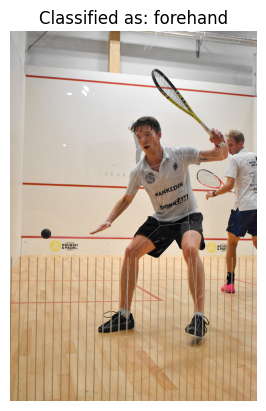

'forehand'

In [ ]:
import joblib

# Load the trained SVM model from the file
svm_clf = joblib.load("/Tennis/svm_model.pkl")

# Function to classify an uploaded image
def classify_image(image_path):
    # Load and preprocess the image (this part remains unchanged)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform pose detection (this part remains unchanged)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        # Extract pose keypoints (this part remains unchanged)
        keypoints = []
        for landmark in results.pose_landmarks.landmark:
            keypoints.append([landmark.x, landmark.y, landmark.z])

        # Flatten keypoints for prediction
        keypoints_flat = np.array([coord for kp in keypoints for coord in kp]).reshape(1, -1)

        # Use the loaded SVM model to classify (instead of retraining)
        prediction = svm_clf.predict(keypoints_flat)[0]
        print(f"Prediction: {prediction}")

        # Draw pose landmarks on the image (this part remains unchanged)
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Convert BGR image to RGB for displaying
        annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

        # Display the image with the pose skeleton
        plt.imshow(annotated_image_rgb)
        plt.title(f"Classified as: {prediction}")
        plt.axis('off')
        plt.show()

        return prediction
    else:
        print("No pose detected in the image.")
        return None

# Example usage:
image_path = "/Tennis/squashForehand.jpg"  # Replace with the path to the uploaded image
classify_image(image_path)
